In [1]:
# Import Numpy & PyTorch
import numpy as np
import torch
# Create tensors.
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)
# Print tensors
print(x)
print(w)
print(b)

tensor(3.)
tensor(4., requires_grad=True)
tensor(5., requires_grad=True)


In [2]:
# Arithmetic operations
y = w * x + b
print(y)

tensor(17., grad_fn=<AddBackward0>)


In [3]:
# Compute gradients
y.backward()

In [4]:
# Display gradients
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

dy/dw: tensor(3.)
dy/db: tensor(1.)


We'll create a model that predicts crop yeilds for apples and oranges (target variables) by looking at the average temperature, rainfall and humidity (input variables or features) in a region. 

![alt text](https://)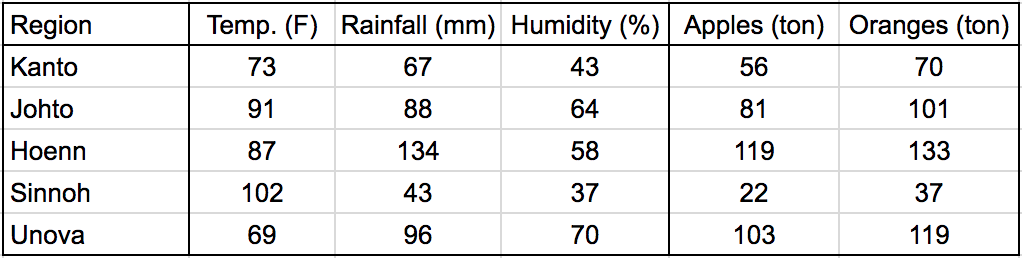

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

yeild_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
yeild_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2
Visually, it means that the yield of apples is a linear or planar function of the temperature, rainfall & humidity.

In [5]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')

In [6]:
# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

In [7]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


Linear Regression Model (from scratch)
The weights and biases can also be represented as matrices, initialized with random values. The first row of w and the first element of b are use to predict the first target variable i.e. yield for apples, and similarly the second for oranges.

In [8]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[-0.5538, -0.4570, -0.6194],
        [-0.8623,  0.7214, -1.1407]], requires_grad=True)
tensor([1.7769, 0.9575], requires_grad=True)


The model is simply a function that performs a matrix multiplication of the input x and the weights w (transposed) and adds the bias b (replicated for each observation).


In [9]:
# Define the model
def model(x):
    return x @ w.t() + b

In [10]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ -95.9104,  -62.7041],
        [-128.4853,  -87.0303],
        [-143.5769,  -43.5515],
        [ -97.2866,  -98.1797],
        [-123.6736,  -69.1334]], grad_fn=<AddBackward0>)


In [11]:
# Compare with targets
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


Because we've started with random weights and biases, the model does not a very good job of predicting the target variables.

**Loss Function**
We can compare the predictions with the actual targets, using the following method:

Calculate the difference between the two matrices (preds and targets).
Square all elements of the difference matrix to remove negative values.
Calculate the average of the elements in the resulting matrix.
The result is a single number, known as the mean squared error (MSE).

In [12]:
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [13]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(33932.1641, grad_fn=<DivBackward0>)


**Compute Gradients**
With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have requires_grad set to True.

In [14]:
# Compute gradients
loss.backward()

In [15]:
# Gradients for weights
print(w)
print(w.grad)

tensor([[-0.5538, -0.4570, -0.6194],
        [-0.8623,  0.7214, -1.1407]], requires_grad=True)
tensor([[-16160.9062, -18137.5996, -11089.8848],
        [-13785.5332, -14593.8535,  -9230.2373]])


In [16]:
# Gradients for bias
print(b)
print(b.grad)

tensor([1.7769, 0.9575], requires_grad=True)
tensor([-193.9866, -164.1198])


A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases.

If a gradient element is positive,
increasing the element's value slightly will increase the loss.
decreasing the element's value slightly will decrease the loss.
If a gradient element is negative,
increasing the element's value slightly will decrease the loss.
decreasing the element's value slightly will increase the loss.
The increase or decrease is proportional to the value of the gradient.

Finally, we'll reset the gradients to zero before moving forward, because PyTorch accumulates gradients.


In [17]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


Adjust weights and biases using gradient descent
We'll reduce the loss and improve our model using the gradient descent algorithm, which has the following steps:

1. Generate predictions
2. Calculate the loss
3. Compute gradients w.r.t the weights and biases
4. Adjust the weights by subtracting a small quantity proportional to the gradient
5. Reset the gradients to zero

In [18]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ -95.9104,  -62.7041],
        [-128.4853,  -87.0303],
        [-143.5769,  -43.5515],
        [ -97.2866,  -98.1797],
        [-123.6736,  -69.1334]], grad_fn=<AddBackward0>)


In [19]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(33932.1641, grad_fn=<DivBackward0>)


In [20]:
# Compute gradients
loss.backward()

In [21]:
# Adjust weights & reset gradients
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [22]:
print(w)

tensor([[-0.3922, -0.2757, -0.5085],
        [-0.7244,  0.8674, -1.0484]], requires_grad=True)


With the new weights and biases, the model should have a lower loss.

In [23]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(22993.5430, grad_fn=<DivBackward0>)


In [24]:
# Train for 100 epochs to further reduce the loss
for i in range(100):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [25]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(198.3691, grad_fn=<DivBackward0>)


In [26]:
# Print predictions
preds

tensor([[ 61.4801,  70.8629],
        [ 80.5224,  89.2699],
        [115.5928, 157.9990],
        [ 43.9612,  38.1074],
        [ 85.9903,  98.8585]], grad_fn=<AddBackward0>)

In [27]:
# Print targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])